In [1]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-07-01 00:00:00"),
                  end=string2ts("2018-03-01 00:00:00"),
                  period=3600*4)
per = 0.85

from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

C:\Users\Daniel.LAPTOP-OBVONK0N\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [2]:
from mldata import ml_data
from orders import orders
from profit import profit

df["ml_data"] = ml_data(df["close"],la=10, pl=False)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"],"ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"]})

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

train.tail(3)

Retorno de estrategia ideal: 42405.599523


,cci,close,dma,ideal_w,kdjd,kdjj,kdjk,macd,macds,price,pricew,rsi,trix,volatility,volumen,vr,wr
date,,,,,,,,,,,,,,,,,
2018-01-23 03:00:00,54.807124,0.000120,-0.000004,1.0,54.630383,80.512011,63.257593,-0.000002,-0.000002,0.000120,0.000120,47.554950,-0.312800,False,558.331852,35.501154,34.161491
2018-01-23 07:00:00,176.899243,0.000125,-0.000003,1.0,59.638420,89.686640,69.654493,-0.000001,-0.000002,0.000125,0.000124,54.137682,-0.273059,True,1068.716270,45.374908,17.551705
2018-01-23 11:00:00,130.454900,0.000122,-0.000002,1.0,62.429823,79.178240,68.012629,-0.000001,-0.000002,0.000122,0.000124,50.023513,-0.233881,False,720.570287,38.468249,35.271101


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

features = ["price","rsi","cci","macds","macd","wr","trix","vr"]

X, y = data[features], data["ideal_w"]
X_train, y_train, X_test, y_test = train[features], train["ideal_w"], test[features], test["ideal_w"]

## Usando paquete Mlxtend

In [4]:
from mlxtend.classifier import EnsembleVoteClassifier


clf1 = RandomForestClassifier(n_estimators=45, max_depth=4, min_samples_split=65)
clf2 = DecisionTreeClassifier(max_depth=3, min_samples_split=250, min_samples_leaf=145)
clf3 = XGBClassifier(n_estimators=9, learning_rate=0.75, gamma=12)
clf4 = SVC(probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4], weights=[1, 1, 1, 1], voting='soft')

predictions = []

for clf, lab in zip([clf1, clf2, clf3, clf4, eclf],
              ['Random Forest', 'Decision Tree', 'XGB', 'SVC', 'Ensemble']):
    clf.fit(X_train, y_train)
    pre = clf.predict(test[features])
    predictions.append(pre)
    print lab, accuracy_score(test["ideal_w"], pre)


Random Forest 0.86301369863
Decision Tree 0.853881278539
XGB 0.853881278539
SVC 1.0
Ensemble 0.945205479452


Retorno de stacking_ensembling: 22.0820696409


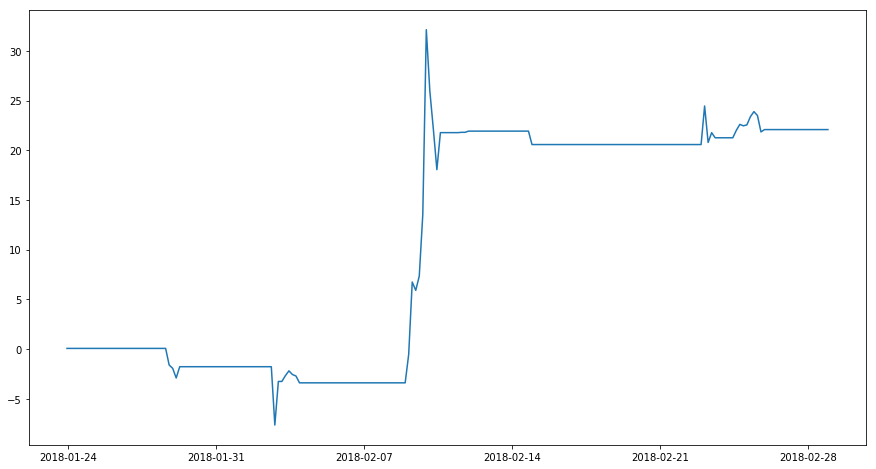

In [5]:
w10 = pd.DataFrame(data={"w":predictions[-1],"price":test["close"]})
w10["orders"] = orders(w10["w"])
w10["w"] = w10["w"].shift(1)
relativeReturn10, v10 = profit(w10)

print 'Retorno de stacking_ensembling: %s'%(relativeReturn10*100)

plt.plot(df.index[int(len(data)*per):],v10*100,label='retorno stacking')

## Usando paquete vecstack

In [6]:
from vecstack import stacking

models = [clf1, clf2, clf4]

### Creando stacking

In [7]:
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.77419355]
    fold  1:  [0.81935484]
    fold  2:  [0.75080906]
    fold  3:  [0.79288026]
    ----
    MEAN:     [0.78430943] + [0.02513089]
    FULL:     [0.78432956]

model  1:     [DecisionTreeClassifier]
    fold  0:  [0.78064516]
    fold  1:  [0.80000000]
    fold  2:  [0.78640777]
    fold  3:  [0.80582524]
    ----
    MEAN:     [0.79321954] + [0.01011674]
    FULL:     [0.79321486]

model  2:     [SVC]
    fold  0:  [0.60322581]
    fold  1:  [0.60000000]
    fold  2:  [0.60841424]
    fold  3:  [0.60841424]
    ----
    MEAN:     [0.60501357] + [0.00358682]
    FULL:     [0.60500808]



### Aplicando modelo de 2 nivel

In [8]:
  # Fit 2nd level model
model = clf3.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.84931507]
